# ENAS for the CIFAR 10 Dataset

sources:

[ENAS-pytorch](https://github.com/carpedm20/ENAS-pytorch)

[Efficient Neural Architecture Search via Parameter Sharing](https://arxiv.org/abs/1802.03268)

[Neural Architecture Search with Reinforcement Learning](https://arxiv.org/abs/1611.01578)

In [1]:
!apt -y update
!apt -y upgrade
!pip install graphviz
!apt-get -y install graphviz
!apt -y install xdg-utils

Get:1 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:2 https://deb.nodesource.com/node_16.x focal InRelease [4583 B]            
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]  
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:7 https://deb.nodesource.com/node_16.x focal/main amd64 Packages [776 B]   
Get:8 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1275 kB]     
Get:10 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1444 kB]m
Get:13 http://archive.ubuntu.com/ubuntu focal-upda

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from Utilities.BatchImageDisplayHelper import BatchImageDisplayHelper
from Utilities.InverseTransforms import UnNormalize

import graphviz
from graphviz import Digraph


## Config

In [3]:
batch_size = 64

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Utils

In [4]:
def train(net, numEpochs):
    for epoch in range(numEpochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print(f'Epoch: {epoch + 1} loss: {running_loss / 2000:.5f}')

    print('Finished Training')
    return net

In [5]:
def testNetwork(testloader, net):
    """
    Test the network on the test set.
    """
    correct = 0
    total = 0
    accuracy = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    return accuracy
    

## Dataset

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

unnormalize = transforms.Compose([
    UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


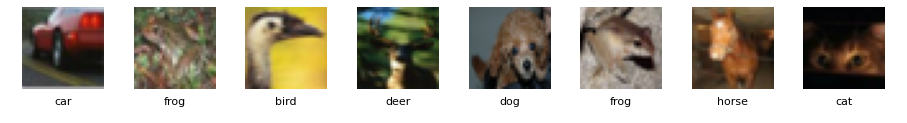

In [7]:
dataiter = BatchImageDisplayHelper.generateBatch(trainset, 8)
images, labels = next(dataiter)
BatchImageDisplayHelper.imshow(images, labels=labels, classes=classes, predictions=None, removeGaps=True, transform=unnormalize)

## Traditional Network Implementation

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    # I hate being dependable, man.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [10]:
net = train(net, 10)

Epoch: 1 loss: 0.89992
Epoch: 2 loss: 0.88409
Epoch: 3 loss: 0.79229
Epoch: 4 loss: 0.71629
Epoch: 5 loss: 0.65734
Epoch: 6 loss: 0.62228
Epoch: 7 loss: 0.59491
Epoch: 8 loss: 0.57288
Epoch: 9 loss: 0.55087
Epoch: 10 loss: 0.53395
Finished Training


## Test the Trained Network

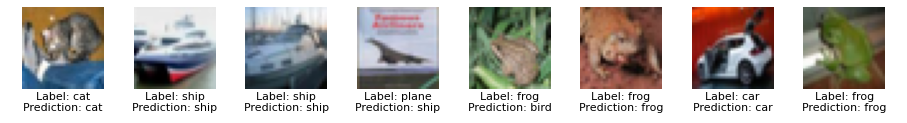

In [11]:
dataiter = BatchImageDisplayHelper.generateBatch(testset, batchSize=8, shuffle=False)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

images = images.to(torch.device('cpu'))
labels = labels.to(torch.device('cpu'))
predicted = predicted.to(torch.device('cpu'))

BatchImageDisplayHelper.imshow(images, labels=labels, classes=classes, predictions=predicted, removeGaps=True, transform=unnormalize)


In [12]:
print(f'Accuracy of the network on the 10000 test images: {testNetwork(testloader, net)} %')

Accuracy of the network on the 10000 test images: 50 %


# ENAS

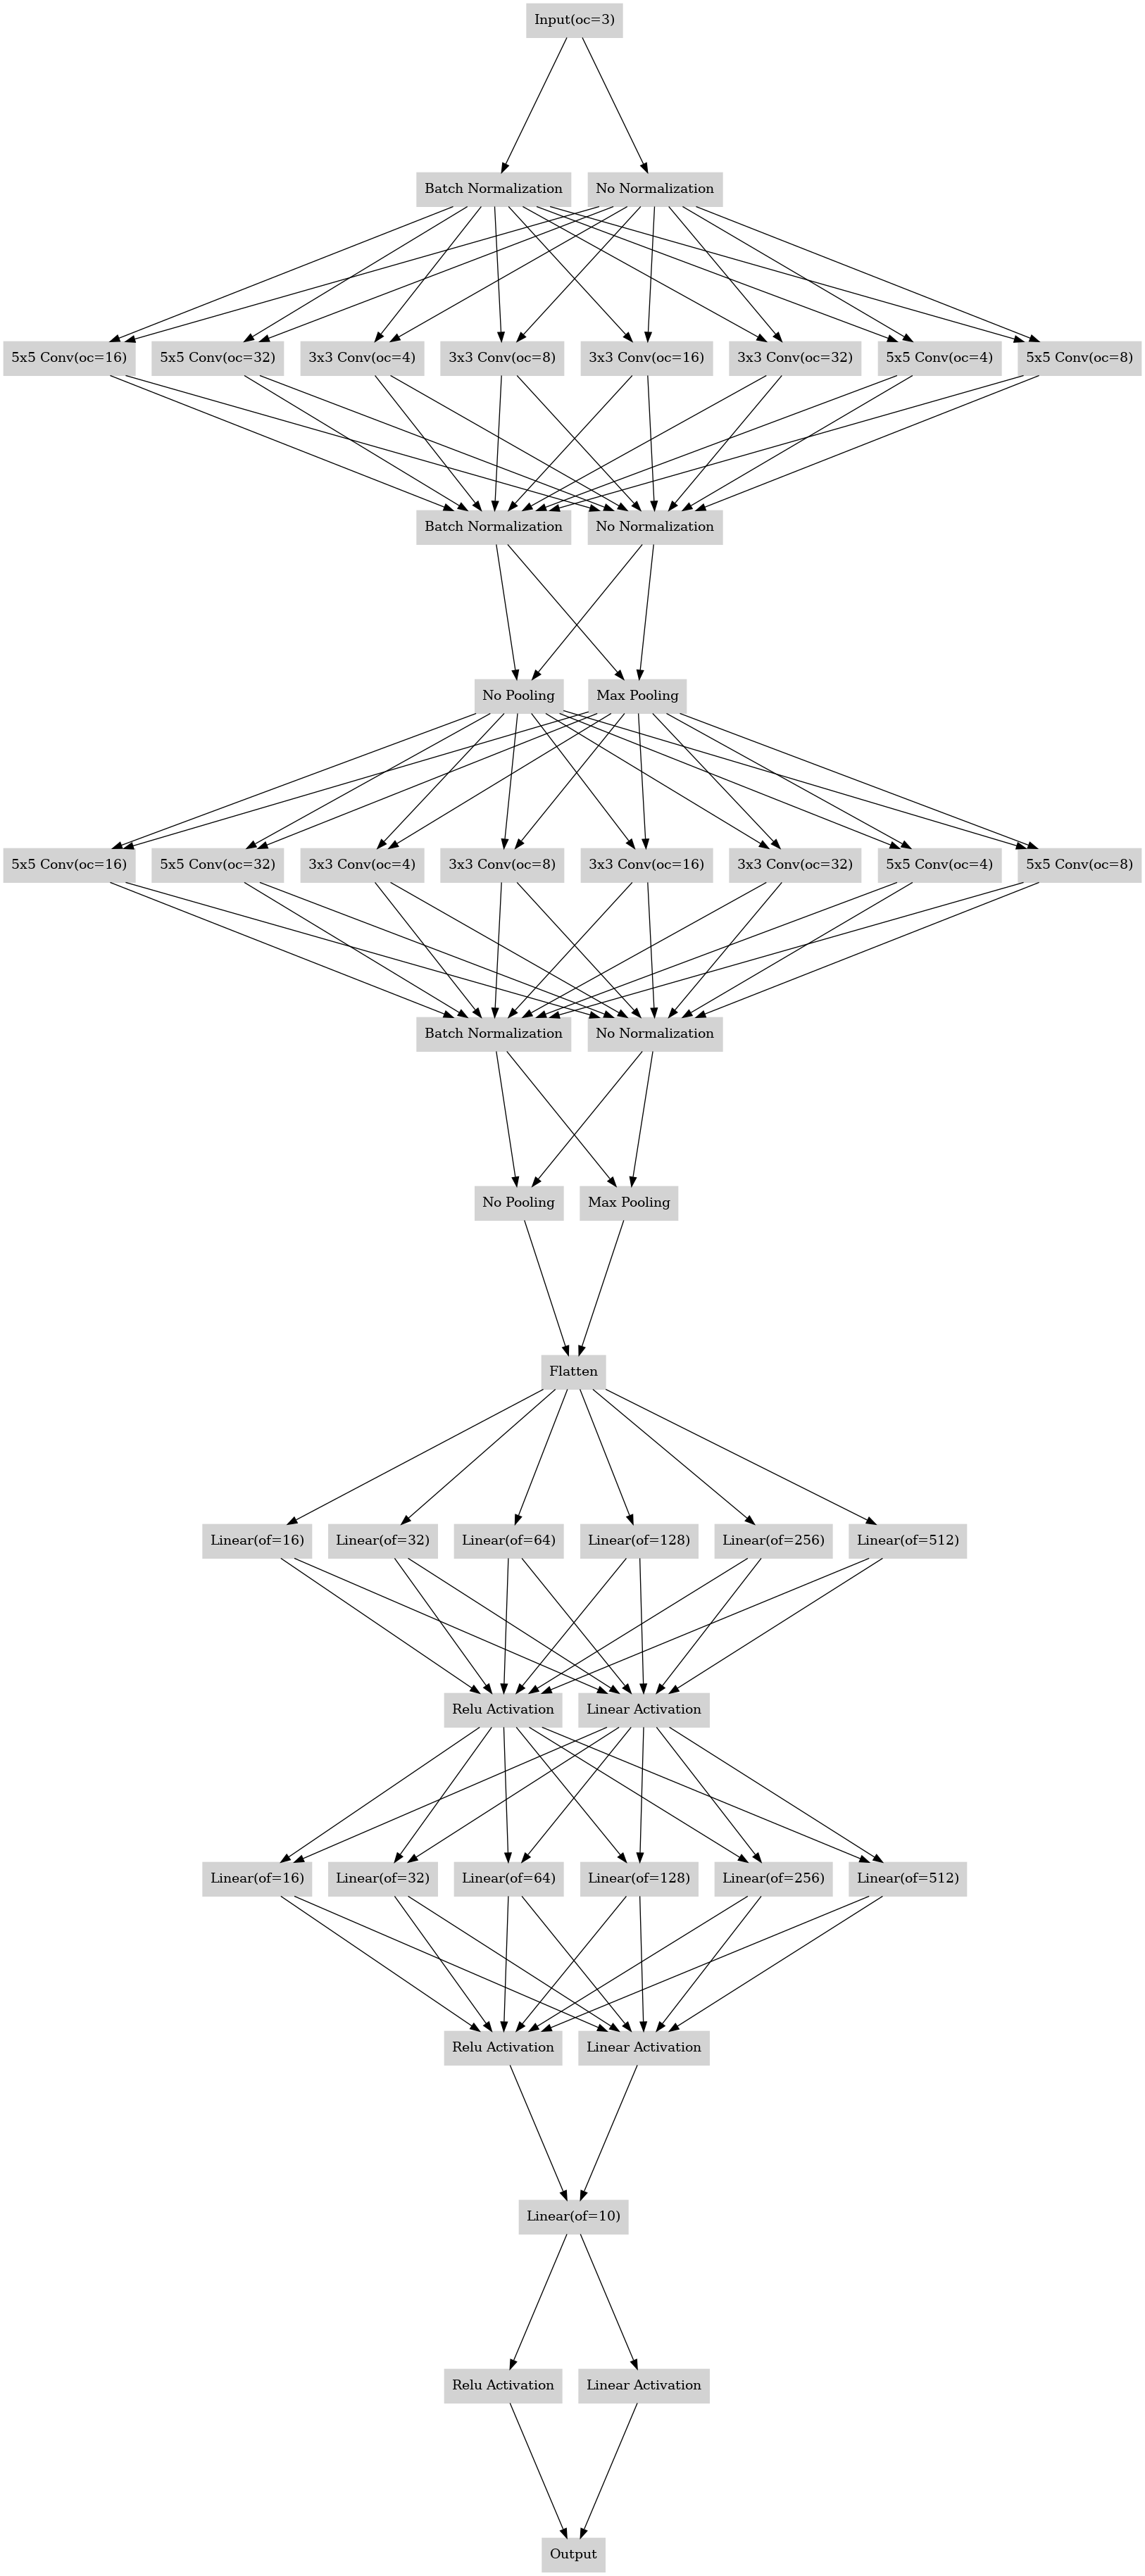

In [2]:
from graphviz import Digraph
from IPython.display import display, Image

# Initialize the graph
g = Digraph('G', filename='enas_network_search_space')

# Define node attributes
# Define graph attributes
g.attr(rankdir='TB')  # 'TB' for top-to-bottom graph, 'LR' for left-to-right
g.attr('node', shape='box', style='filled', color='lightgrey')
g.attr(ranksep='2.0')  # Increase the space between layers, adjust the value as needed


# Add nodes representing each layer and operation
# oc stands for Out Channels
g.node('Input', 'Input(oc=3)')

g.node('L0_BatchNorm', 'Batch Normalization')
g.node('L0_NoNorm', 'No Normalization')

g.node('L1_C3_OC4', '3x3 Conv(oc=4)')
g.node('L1_C3_OC8', '3x3 Conv(oc=8)')
g.node('L1_C3_OC16', '3x3 Conv(oc=16)')
g.node('L1_C3_OC32', '3x3 Conv(oc=32)')
g.node('L1_C5_OC4', '5x5 Conv(oc=4)')
g.node('L1_C5_OC8', '5x5 Conv(oc=8)')
g.node('L1_C5_OC16', '5x5 Conv(oc=16)')
g.node('L1_C5_OC32', '5x5 Conv(oc=32)')

g.node('L1_BatchNorm', 'Batch Normalization')
g.node('L1_NoNorm', 'No Normalization')

g.node('L1_I', 'No Pooling')
g.node('L1_MP', 'Max Pooling')

g.node('L2_C3_OC4', '3x3 Conv(oc=4)')
g.node('L2_C3_OC8', '3x3 Conv(oc=8)')
g.node('L2_C3_OC16', '3x3 Conv(oc=16)')
g.node('L2_C3_OC32', '3x3 Conv(oc=32)')
g.node('L2_C5_OC4', '5x5 Conv(oc=4)')
g.node('L2_C5_OC8', '5x5 Conv(oc=8)')
g.node('L2_C5_OC16', '5x5 Conv(oc=16)')
g.node('L2_C5_OC32', '5x5 Conv(oc=32)')

g.node('L2_BatchNorm', 'Batch Normalization')
g.node('L2_NoNorm', 'No Normalization')

g.node('L2_I', 'No Pooling')
g.node('L2_MP', 'Max Pooling')

g.node('L3_Flat', 'Flatten')

g.node('L3_Linear_of16', 'Linear(of=16)')
g.node('L3_Linear_of32', 'Linear(of=32)')
g.node('L3_Linear_of64', 'Linear(of=64)')
g.node('L3_Linear_of128', 'Linear(of=128)')
g.node('L3_Linear_of256', 'Linear(of=256)')
g.node('L3_Linear_of512', 'Linear(of=512)')

g.node('L3_Relu', 'Relu Activation')
g.node('L3_Linear_Act', 'Linear Activation')

g.node('L4_Linear_of16', 'Linear(of=16)')
g.node('L4_Linear_of32', 'Linear(of=32)')
g.node('L4_Linear_of64', 'Linear(of=64)')
g.node('L4_Linear_of128', 'Linear(of=128)')
g.node('L4_Linear_of256', 'Linear(of=256)')
g.node('L4_Linear_of512', 'Linear(of=512)')

g.node('L4_Relu', 'Relu Activation')
g.node('L4_Linear_Act', 'Linear Activation')

g.node('Final_Linear_of10', 'Linear(of=10)')
g.node('L5_Relu', 'Relu Activation')
g.node('L5_Linear_Act', 'Linear Activation')
g.node('Output', 'Output')

# Add edges to show potential paths
g.edge('Input', 'L0_BatchNorm')
g.edge('Input', 'L0_NoNorm')

g.edge('L0_BatchNorm', 'L1_C3_OC4')
g.edge('L0_BatchNorm', 'L1_C3_OC8')
g.edge('L0_BatchNorm', 'L1_C3_OC16')
g.edge('L0_BatchNorm', 'L1_C3_OC32')
g.edge('L0_BatchNorm', 'L1_C5_OC4')
g.edge('L0_BatchNorm', 'L1_C5_OC8')
g.edge('L0_BatchNorm', 'L1_C5_OC16')
g.edge('L0_BatchNorm', 'L1_C5_OC32')

g.edge('L0_NoNorm', 'L1_C3_OC4')
g.edge('L0_NoNorm', 'L1_C3_OC8')
g.edge('L0_NoNorm', 'L1_C3_OC16')
g.edge('L0_NoNorm', 'L1_C3_OC32')
g.edge('L0_NoNorm', 'L1_C5_OC4')
g.edge('L0_NoNorm', 'L1_C5_OC8')
g.edge('L0_NoNorm', 'L1_C5_OC16')
g.edge('L0_NoNorm', 'L1_C5_OC32')

g.edge('L1_C3_OC4', 'L1_BatchNorm')
g.edge('L1_C3_OC8', 'L1_BatchNorm')
g.edge('L1_C3_OC16', 'L1_BatchNorm')
g.edge('L1_C3_OC32', 'L1_BatchNorm')
g.edge('L1_C5_OC4', 'L1_BatchNorm')
g.edge('L1_C5_OC8', 'L1_BatchNorm')
g.edge('L1_C5_OC16', 'L1_BatchNorm')
g.edge('L1_C5_OC32', 'L1_BatchNorm')

g.edge('L1_C3_OC4', 'L1_NoNorm')
g.edge('L1_C3_OC8', 'L1_NoNorm')
g.edge('L1_C3_OC16', 'L1_NoNorm')
g.edge('L1_C3_OC32', 'L1_NoNorm')
g.edge('L1_C5_OC4', 'L1_NoNorm')
g.edge('L1_C5_OC8', 'L1_NoNorm')
g.edge('L1_C5_OC16', 'L1_NoNorm')
g.edge('L1_C5_OC32', 'L1_NoNorm')

g.edge('L1_BatchNorm', 'L1_I')
g.edge('L1_BatchNorm', 'L1_MP')
g.edge('L1_NoNorm', 'L1_I')
g.edge('L1_NoNorm', 'L1_MP')

g.edge('L1_I', 'L2_C3_OC4')
g.edge('L1_I', 'L2_C3_OC8')
g.edge('L1_I', 'L2_C3_OC16')
g.edge('L1_I', 'L2_C3_OC32')
g.edge('L1_I', 'L2_C5_OC4')
g.edge('L1_I', 'L2_C5_OC8')
g.edge('L1_I', 'L2_C5_OC16')
g.edge('L1_I', 'L2_C5_OC32')

g.edge('L1_MP', 'L2_C3_OC4')
g.edge('L1_MP', 'L2_C3_OC8')
g.edge('L1_MP', 'L2_C3_OC16')
g.edge('L1_MP', 'L2_C3_OC32')
g.edge('L1_MP', 'L2_C5_OC4')
g.edge('L1_MP', 'L2_C5_OC8')
g.edge('L1_MP', 'L2_C5_OC16')
g.edge('L1_MP', 'L2_C5_OC32')

g.edge('L2_C3_OC4', 'L2_BatchNorm')
g.edge('L2_C3_OC8', 'L2_BatchNorm')
g.edge('L2_C3_OC16', 'L2_BatchNorm')
g.edge('L2_C3_OC32', 'L2_BatchNorm')
g.edge('L2_C5_OC4', 'L2_BatchNorm')
g.edge('L2_C5_OC8', 'L2_BatchNorm')
g.edge('L2_C5_OC16', 'L2_BatchNorm')
g.edge('L2_C5_OC32', 'L2_BatchNorm')

g.edge('L2_C3_OC4', 'L2_NoNorm')
g.edge('L2_C3_OC8', 'L2_NoNorm')
g.edge('L2_C3_OC16', 'L2_NoNorm')
g.edge('L2_C3_OC32', 'L2_NoNorm')
g.edge('L2_C5_OC4', 'L2_NoNorm')
g.edge('L2_C5_OC8', 'L2_NoNorm')
g.edge('L2_C5_OC16', 'L2_NoNorm')
g.edge('L2_C5_OC32', 'L2_NoNorm')

g.edge('L2_BatchNorm', 'L2_I')
g.edge('L2_BatchNorm', 'L2_MP')
g.edge('L2_NoNorm', 'L2_I')
g.edge('L2_NoNorm', 'L2_MP')

g.edge('L2_I', 'L3_Flat')
g.edge('L2_MP', 'L3_Flat')

g.edge('L3_Flat', 'L3_Linear_of512')
g.edge('L3_Flat', 'L3_Linear_of256')
g.edge('L3_Flat', 'L3_Linear_of128')
g.edge('L3_Flat', 'L3_Linear_of64')
g.edge('L3_Flat', 'L3_Linear_of32')
g.edge('L3_Flat', 'L3_Linear_of16')

g.edge('L3_Linear_of512', 'L3_Relu')
g.edge('L3_Linear_of256', 'L3_Relu')
g.edge('L3_Linear_of128', 'L3_Relu')
g.edge('L3_Linear_of64', 'L3_Relu')
g.edge('L3_Linear_of32', 'L3_Relu')
g.edge('L3_Linear_of16', 'L3_Relu')

g.edge('L3_Linear_of512', 'L3_Linear_Act')
g.edge('L3_Linear_of256', 'L3_Linear_Act')
g.edge('L3_Linear_of128', 'L3_Linear_Act')
g.edge('L3_Linear_of64', 'L3_Linear_Act')
g.edge('L3_Linear_of32', 'L3_Linear_Act')
g.edge('L3_Linear_of16', 'L3_Linear_Act')

g.edge('L3_Relu', 'L4_Linear_of512')
g.edge('L3_Linear_Act', 'L4_Linear_of512')
g.edge('L3_Relu', 'L4_Linear_of256')
g.edge('L3_Linear_Act', 'L4_Linear_of256')
g.edge('L3_Relu', 'L4_Linear_of128')
g.edge('L3_Linear_Act', 'L4_Linear_of128')
g.edge('L3_Relu', 'L4_Linear_of64')
g.edge('L3_Linear_Act', 'L4_Linear_of64')
g.edge('L3_Relu', 'L4_Linear_of32')
g.edge('L3_Linear_Act', 'L4_Linear_of32')
g.edge('L3_Relu', 'L4_Linear_of16')
g.edge('L3_Linear_Act', 'L4_Linear_of16')

g.edge('L4_Linear_of512', 'L4_Relu')
g.edge('L4_Linear_of256', 'L4_Relu')
g.edge('L4_Linear_of128', 'L4_Relu')
g.edge('L4_Linear_of64', 'L4_Relu')
g.edge('L4_Linear_of32', 'L4_Relu')
g.edge('L4_Linear_of16', 'L4_Relu')

g.edge('L4_Linear_of512', 'L4_Linear_Act')
g.edge('L4_Linear_of256', 'L4_Linear_Act')
g.edge('L4_Linear_of128', 'L4_Linear_Act')
g.edge('L4_Linear_of64', 'L4_Linear_Act')
g.edge('L4_Linear_of32', 'L4_Linear_Act')
g.edge('L4_Linear_of16', 'L4_Linear_Act')

g.edge('L4_Relu', 'Final_Linear_of10')
g.edge('L4_Linear_Act', 'Final_Linear_of10')

g.edge('Final_Linear_of10', 'L5_Relu')
g.edge('Final_Linear_of10', 'L5_Linear_Act')

g.edge('L5_Relu', 'Output')
g.edge('L5_Linear_Act', 'Output')

# Specify the output format and render the graph
g.format = 'png'
g.render('enas_network_search_space_visualization')

# Display the graph inline in Jupyter notebook
display(Image(filename='enas_network_search_space_visualization.png'))


In [118]:
from enum import Enum

class NodeType(Enum):
    INPUT = 'input'
    OUTPUT = 'output'
    CONVOLUTION = 'convolution'
    NORMALIZATION = 'normalization'
    POOLING = 'pooling'
    FLATTEN = 'flatten'
    LINEAR = 'linear'
    ACTIVATION = 'activation'
    

class NormalizationType(Enum):
    NO_NORM = 'noNorm'
    BATCH_NORM = 'batchNorm'
    
    
class PoolingType(Enum):
    NO_POOLING = 'none'
    MAX_POOLING = 'maxPooling'
    

class ActivationType(Enum):
    RELU = 'reluActivation'
    LINEAR = 'linearActivation'
       

class Node:
    def __init__(self, name, displayName):
        self.name = name
        self.displayName = displayName
        
    def __str__(self):
        return self.displayName
    
    def __repr__(self):
        return self.displayName
    
    
class InputNode(Node):
    def __init__(self, numChannels):
        self.name = 'input'
        self.displayName = 'Input(numChannels=' + str(numChannels) + ')'
        self.numChannels = numChannels
        
        
class OutputNode(Node):
    def __init__(self):
        self.name = 'output'
        self.displayName = 'Output'
        
        
class NormalizationNode(Node):
    def __init__(self, name):
        self.displayName = 'No Normalization'
        if 'batchNorm' in name:
            self.displayName = 'Batch Normalization'
        self.name = name    
        
        
class PoolingNode(Node):
    def __init__(self, name):
        self.displayName = 'No Pooling'
        if 'maxPooling' in name:
            self.displayName = 'Max Pooling'
        self.name = name 
        
        
class ConvolutionalNode(Node):
    def __init__(self, name, kernelSize, outputChannels):
        self.name = name
        self.displayName = str(kernelSize[0]) + 'x' + str(kernelSize[1]) + ' Conv(oc=' + str(outputChannels) + ')'
        self.kernelSize = kernelSize
        self.outputChannels = outputChannels
        
        
class FlattenNode(Node):
    def __init__(self, name):
        self.name = name
        self.displayName = 'Flatten'
        
        
class LinearNode(Node):
    def __init__(self, name, outFeatures):
        self.name = name
        self.outFeatures = outFeatures
        self.displayName = 'Linear(of=' + str(outFeatures) + ')'
        
        
class ActivationNode(Node):
    def __init__(self, name, activationType):
        self.activationType = activationType
        self.name = name
        if self.activationType == activationType.LINEAR:
            self.displayName = 'Linear Activation'
        elif self.activationType == activationType.RELU:
            self.displayName = 'Relu Activation'
        else:
            raise ValueError(f"Unknown activation type: {activationType}")
        
        
class NodeFactory:
    def createNode(self, nodeType, *args, **kwargs):
        if nodeType == NodeType.INPUT:
            return InputNode(*args, **kwargs)
        if nodeType == NodeType.OUTPUT:
            return OutputNode(*args, **kwargs)
        if nodeType == NodeType.NORMALIZATION:
            return NormalizationNode(*args, **kwargs)
        if nodeType == NodeType.POOLING:
            return PoolingNode(*args, **kwargs)
        if nodeType == NodeType.CONVOLUTION:
            return ConvolutionalNode(*args, **kwargs)
        if nodeType == NodeType.FLATTEN:
            return FlattenNode(*args, **kwargs)
        if nodeType == NodeType.LINEAR:
            return LinearNode(*args, **kwargs)
        if nodeType == NodeType.ACTIVATION:
            return ActivationNode(*args, **kwargs)

        raise ValueError(f"Unknown node type: {nodeType}")

        

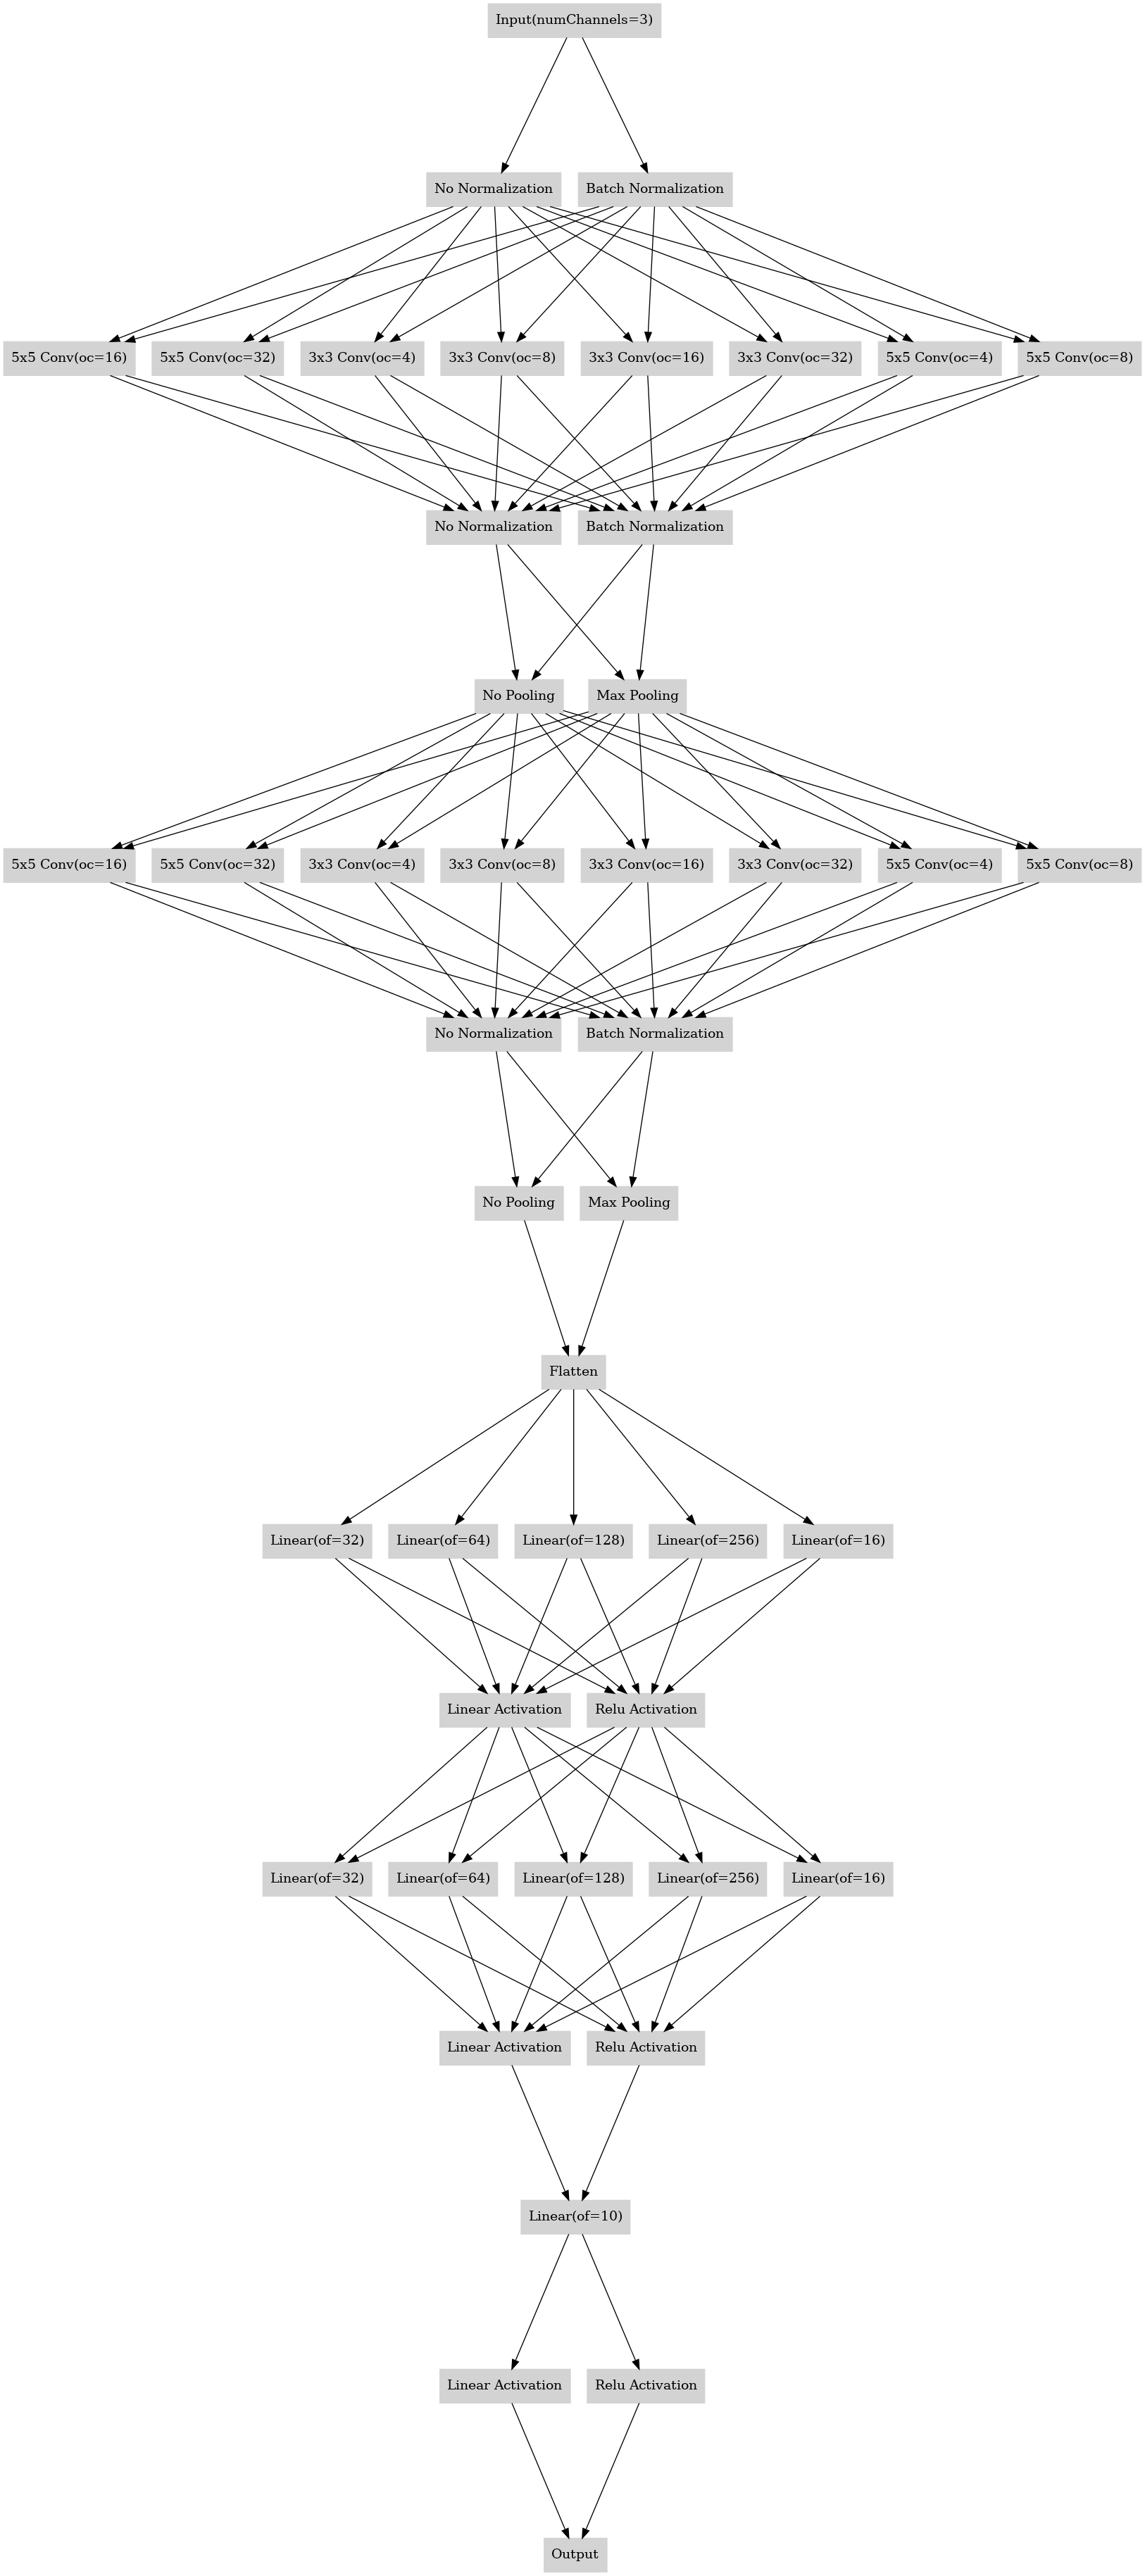

In [119]:
from graphviz import Digraph
from IPython.display import display, Image
import copy


class Graph:
    def __init__(self):
        self.ALLOWED_KERNEL_SIZES = {(3, 3), (5, 5)}
        self.ALLOWED_CONVOLUTION_CHANNELS = [4, 8, 16, 32]
        self.ALLOWED_LINEAR_FEATURES = [16, 32, 64, 128, 256]
        self.graph = {}
        self.normalizationOptions = [NormalizationType.NO_NORM, NormalizationType.BATCH_NORM]    
        self.poolingOptions = [PoolingType.NO_POOLING, PoolingType.MAX_POOLING]    
        self.activationOptions = [ActivationType.LINEAR, ActivationType.RELU]
        self.nodeFactory = NodeFactory()
        self.numConvLayers = 2
        self.numLinearLayers = 3
        self.numClasses = 10
        self.prevNodes = []
        self.curNodes = []
        self.layer = 0
        
    def construct(self):
        self.layer = 0
        self.prevNodes = []
        self.curNodes = []   
        self.addInputLayer()    
        self.addConvolutionalLayers()       
        self.addFlattenLayer()
        self.addLinearLayers()            
        self.addOutputLayer() 
        
    def addActivationLayer(self):
        for act in self.activationOptions:
            nodeName = 'L' + str(self.layer) + '_' + act.value
            self.addNode(nodeType=NodeType.ACTIVATION, name=nodeName, activationType=act)
        self.prevNodes = self.curNodes
        self.curNodes = []
          
    def addConvolutionalLayer(self):
        for kernel in self.ALLOWED_KERNEL_SIZES:
            for oc in self.ALLOWED_CONVOLUTION_CHANNELS:
                nodeName = 'L' + str(self.layer) + '_' + str(kernel[0]) + 'x' + str(kernel[1]) + '_Conv(oc=' + str(oc) + ')'
                self.addNode(nodeType=NodeType.CONVOLUTION, name=nodeName, kernelSize=kernel, outputChannels=oc)
        self.prevNodes = self.curNodes
        self.curNodes = []
                         
    def addConvolutionalLayers(self):
        for i in range(self.numConvLayers):        
            self.layer += 1
            self.addConvolutionalLayer()                                        
            self.addNormalizationLayer()                
            self.addPoolingLayer()
            
    def addFlattenLayer(self):
        self.addNode(nodeType=NodeType.FLATTEN, name='L' + str(self.layer) + '_' + 'flatten')
        self.prevNodes = self.curNodes
        self.curNodes = []
        
    def addInputLayer(self):
        self.addNode(nodeType=NodeType.INPUT, numChannels=3)
        self.prevNodes = self.curNodes
        self.curNodes = []
        self.addNormalizationLayer()
        
    def addOutputLayer(self):
        self.addNode(nodeType=NodeType.OUTPUT)
    
    def addLinearLayer(self):
        for of in self.ALLOWED_LINEAR_FEATURES:
            nodeName = 'L' + str(self.layer) + '_Linear(of=' + str(of) + ')' 
            self.addNode(nodeType=NodeType.LINEAR, name=nodeName, outFeatures=of)
        self.prevNodes = self.curNodes
        self.curNodes = []
     
    def addLinearLayers(self):
        for i in range(self.numLinearLayers - 1):
            self.layer += 1            
            self.addLinearLayer()
            self.addActivationLayer()                                                  
        self.layer += 1
        nodeName = 'L' + str(self.layer) + '_Linear(of=' + str(10) + ')' 
        self.addNode(nodeType=NodeType.LINEAR, name = nodeName, outFeatures=self.numClasses)    
        self.prevNodes = self.curNodes
        self.curNodes = []
        self.addActivationLayer()
            
    def addNode(self, **kwargs):
        node = self.nodeFactory.createNode(**kwargs)      
        self.graph[node.name] = {'node': node, 'edges': []}
        for prev in self.prevNodes:
            prevNode = self.graph[prev]
            prevNode['edges'].append(node.name)
        self.curNodes.append(node.name)  
        
    def addNormalizationLayer(self):
        for opt in self.normalizationOptions:
            nodeName = 'L' + str(self.layer) + '_' + opt.value
            self.addNode(nodeType=NodeType.NORMALIZATION, name=nodeName)
        self.prevNodes = self.curNodes
        self.curNodes = []         
                
    def addPoolingLayer(self):
        for opt in self.poolingOptions:
            nodeName = 'L' + str(self.layer) + '_' + opt.value
            self.addNode(nodeType=NodeType.POOLING, name=nodeName)
        self.prevNodes = self.curNodes
        self.curNodes = []
              
    def render(self):
        # Initialize the graph
        g = Digraph('G', filename='enas_network_search_space')

        # Define graph attributes
        g.attr(rankdir='TB')  # 'TB' for top-to-bottom graph, 'LR' for left-to-right
        g.attr('node', shape='box', style='filled', color='lightgrey')
        g.attr(ranksep='2.0')  # Increase the space between layers, adjust the value as needed
        
        # Add Nodes
        for val in self.graph.values():
            node = val['node']
            g.node(node.name, node.displayName)
            
        # Add Edges
        for val in self.graph.values():
            node = val['node']
            for edge in val['edges']:
                g.edge(node.name, edge)
                
        # Specify the output format and render the graph
        g.format = 'png'
        g.render('enas_network_search_space_visualization')

        # Display the graph inline in Jupyter notebook
        display(Image(filename='enas_network_search_space_visualization.png'))

        
graph = Graph()
graph.construct()
#print(graph.graph)
graph.render()

In [25]:
from graphviz import Digraph
from IPython.display import display, Image

class Graph:
    def __init__(self, layers):
        self.graph = Digraph('G', filename='enas_network_search_space')
        self.setup_graph_attributes()
        self.add_nodes()
        self.add_edges()

    def setup_graph_attributes(self):
        self.graph.attr(rankdir='TB')
        self.graph.attr('node', shape='box', style='filled', color='lightgrey')
        self.graph.attr(ranksep='2.0')

    def add_nodes(self):
        # Add your nodes here
        self.graph.node('Input', 'Input(oc=3)')
        # ... Add other nodes similarly
        # Example:
        self.graph.node('L0_BatchNorm', 'Batch Normalization')
        self.graph.node('L0_NoNorm', 'No Normalization')
        # ... Continue for all nodes

    def add_edges(self):
        # Add edges to show potential paths
        self.graph.edge('Input', 'L0_BatchNorm')
        self.graph.edge('Input', 'L0_NoNorm')
        # ... Continue for all edges

    def render_and_display_graph(self):
        self.graph.format = 'png'
        self.graph.render('enas_network_search_space_visualization')
        display(Image(filename='enas_network_search_space_visualization.png'))


## Shared Conv2D

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import math

class SharedConv2d(nn.Module):
    def __init__(self, kernelSize, maxInChannels, maxOutChannels, useMaxPool=False):
        super(SharedConv2d, self).__init__()
        self.kernelSize = kernelSize
        self.maxInChannels = maxInChannels
        self.maxOutChannels = maxOutChannels
        self.useMaxPool = useMaxPool

        # Initialize the weights and biases
        self.weight = nn.Parameter(torch.Tensor(maxOutChannels, maxInChannels, kernelSize, kernelSize))
        self.bias = nn.Parameter(torch.Tensor(maxOutChannels))
        
        self.pool = nn.MaxPool2d(2,2)

        # Initialize weights using Kaiming (He) initialization
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))  # 'a' is the slope of the rectifier used after this layer
        if self.bias is not None:
            # Initialize bias with a value between -1/sqrt(fan_in) and 1/sqrt(fan_in)
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x, inChannels, outChannels):
        weight = self.weight[:outChannels, :inChannels, :, :]
        bias = self.bias[:outChannels]
        x = F.conv2d(x, weight, bias)
        if self.useMaxPool:
            x = self.pool(x)
        return x

## Shared Linear

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class SharedLinear(nn.Module):
    def __init__(self, maxInFeatures, maxOutFeatures, useBatchnorm=False, dropoutRate=0.0):
        super(SharedLinear, self).__init__()
        self.maxInFeatures = maxInFeatures
        self.maxOutFeatures = maxOutFeatures
        self.useBatchnorm = useBatchnorm
        self.dropoutRate = dropoutRate

        # Initialize the weights and biases for the maximum configuration
        self.weight = nn.Parameter(torch.Tensor(maxOutFeatures, maxInFeatures))
        self.bias = nn.Parameter(torch.Tensor(maxOutFeatures))

        # Initialize weights using Kaiming (He) initialization
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in = maxInFeatures  # Number of input features
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

        # Batch normalization layer
        #if self.useBatchnorm:
        #    self.batchnorm = nn.BatchNorm1d(maxOutFeatures)

        # Dropout layer
        #self.dropout = nn.Dropout(p=dropoutRate)

    def forward(self, x, inChannels, outChannels):
        # Dynamically select the subset of weights and biases
        weight = self.weight[:outChannels, :inChannels]
        bias = self.bias[:outChannels]
        
        # Flatten input if not already flat
        if x.dim() > 2:
            x = torch.flatten(x, 1)
        x = F.linear(x, weight, bias)

        #if self.useBatchnorm:
        #    x = self.batchnorm(x)

        #x = self.dropout(x)
        
        return x


## Node

In [5]:
import torch.nn as nn

class Node(nn.Module):
    """
    Defines a node that contains a set of predefined operations and shared weights. 
    
        0: 3x3 Convolution without max pooling
        1: 3x3 Convolution with max pooling
        2: 5x5 Convolution without max pooling
        3: 5x5 Convolution with max pooling
        4: Linear layer
    """
    def __init__(self, maxConvInChannels, maxConvOutChannels, maxLinearInFeatures, 
                 maxLinearOutFeatures):
        super(Node, self).__init__()
        
        self.maxConvInChannels = maxConvInChannels
        self.maxConvOutChannels = maxConvOutChannels
        self.maxLinearInFeatures = maxLinearInFeatures
        self.maxLinearOutFeatures = maxLinearOutFeatures
        
        self.operations = nn.ModuleList([
            SharedConv2d(kernelSize=3, maxInChannels=maxConvInChannels, maxOutChannels=maxConvOutChannels),
            SharedConv2d(kernelSize=3, maxInChannels=maxConvInChannels, maxOutChannels=maxConvOutChannels, useMaxPool=True),
            SharedConv2d(kernelSize=5, maxInChannels=maxConvInChannels,maxOutChannels=maxConvOutChannels),
            SharedConv2d(kernelSize=5, maxInChannels=maxConvInChannels, maxOutChannels=maxConvOutChannels, useMaxPool=True),
            SharedLinear(maxInFeatures=maxLinearInFeatures, maxOutFeatures=maxLinearOutFeatures)   
        ])
                
    def forward(self, x, opInd, inChannels, outChannels):
        return self.operations[opInd](x, inChannels, outChannels)
        
        

## Network Implementation

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.nodes = nn.ModuleList([
            Node(maxConvInChannels=20, maxConvOutChannels=20, maxLinearInFeatures=400, maxLinearOutFeatures=400),
            Node(maxConvInChannels=20, maxConvOutChannels=20, maxLinearInFeatures=400, maxLinearOutFeatures=400),
            Node(maxConvInChannels=20, maxConvOutChannels=20, maxLinearInFeatures=400, maxLinearOutFeatures=400),
            Node(maxConvInChannels=20, maxConvOutChannels=20, maxLinearInFeatures=400, maxLinearOutFeatures=400),
            Node(maxConvInChannels=20, maxConvOutChannels=20, maxLinearInFeatures=400, maxLinearOutFeatures=400),
        ])
        self.ops = [3, 3, 4, 4, 4]
        self.numChannels = [(3, 6), (6, 16), (400, 120), (120, 84), (84, 10)]
        

    def forward(self, x):        
        for i in range(len(self.nodes)):
            # Expecting lengths of all lists to be the same for now
            x = self.nodes[i](x, self.ops[i], self.numChannels[i][0], self.numChannels[i][1])
        return x


net = Net().to(device)

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [19]:
net = train(net, 10)

Epoch: 1 loss: 0.90033
Epoch: 2 loss: 0.89216
Epoch: 3 loss: 0.81157
Epoch: 4 loss: 0.77237
Epoch: 5 loss: 0.72931
Epoch: 6 loss: 0.67928
Epoch: 7 loss: 0.63350
Epoch: 8 loss: 0.61161
Epoch: 9 loss: 0.59419
Epoch: 10 loss: 0.57781
Finished Training


## Test the Trained Network

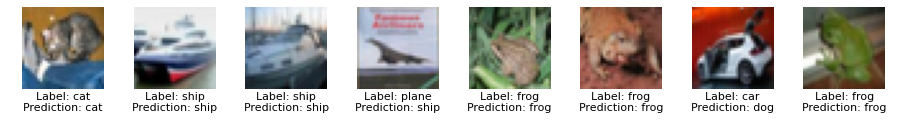

In [20]:
dataiter = BatchImageDisplayHelper.generateBatch(testset, batchSize=8, shuffle=False)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

images = images.to(torch.device('cpu'))
labels = labels.to(torch.device('cpu'))
predicted = predicted.to(torch.device('cpu'))

BatchImageDisplayHelper.imshow(images, labels=labels, classes=classes, predictions=predicted, removeGaps=True, transform=unnormalize)


In [21]:
print(f'Accuracy of the network on the 10000 test images: {testNetwork(testloader, net)} %')

Accuracy of the network on the 10000 test images: 48 %


## Configure Subnetwork 2

In [146]:
net.numChannels = [(3, 8), (8, 16), (400, 128), (128, 64), (64, 10)]

## Train Subnetwork 2

In [147]:
net = train(net, 10)

Epoch: 1 loss: 0.56407
Epoch: 2 loss: 0.55068
Epoch: 3 loss: 0.53941
Epoch: 4 loss: 0.52890
Epoch: 5 loss: 0.51821
Epoch: 6 loss: 0.51004
Epoch: 7 loss: 0.50091
Epoch: 8 loss: 0.49252
Epoch: 9 loss: 0.48422
Epoch: 10 loss: 0.47661
Finished Training


## Test Subnetwork 2

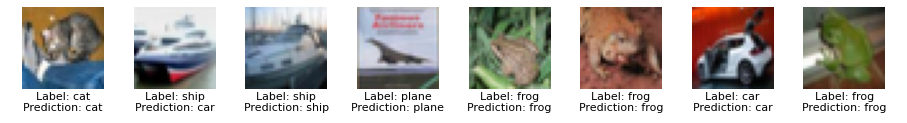

In [148]:
dataiter = BatchImageDisplayHelper.generateBatch(testset, batchSize=8, shuffle=False)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

images = images.to(torch.device('cpu'))
labels = labels.to(torch.device('cpu'))
predicted = predicted.to(torch.device('cpu'))

BatchImageDisplayHelper.imshow(images, labels=labels, classes=classes, predictions=predicted, removeGaps=True, transform=unnormalize)


In [149]:
print(f'Accuracy of the network on the 10000 test images: {testNetwork(testloader, net)} %')

Accuracy of the network on the 10000 test images: 55 %
